<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/kk_mvp_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-02-17
Version: 1.0

Description:
    This notebook builds a topic modelling and sentiment analysis pipeline
    to analyse a representative sample of JPM quarterly call trancripts from 2023-2024.

===================================================
"""

'\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-02-17\nVersion: 1.0\n\nDescription:\n    This notebook builds an end to end NLP pipeline that runs topic modelling,\n    sentiment analysis, and summarisation of JPM quarterly call trancripts from 2023-2024.\n\n===================================================\n'

**Task**

Model the transcript data by analyst and by selected quarters using BERTopic, FinBert and LLM model (Flan-T5).

**Data**

- JMP bank, 2023-2024, Management & Q&A transcripts
- preprocessed with pdf parsing, regex-based segmentation, and structured extraction with GPT-4, and converted into a dataframe
- cleaned column added for questions, answers and management text

**Requirements**

1. finBERt returns sentiment accuracy
2. LLM model returns better sentiment accuracy
3. BERTopic performs accurate topic extraction
4. LLM is able to capture more topic context and provide summarisation of those
5. Analyst topics of interest and sentiment varies widely quarter by quarter
6. Topics and sentiment comparison between analysts.

**Approach**

Topic model -> Sentiment analysis -> Insight + Comparison

- First, topics are identified freely by the model on each transcript
- Second the model is trained with G-SIB assessment topics
- Third, sentiment analysis is run on the resulting four files (Q&A and management - with free topics, and trained topics)
- Fourth, all are compared against each other to find best insights

**Benchmark analysis**

- **comparison between model types and their results** (apply like-for-like rules when comparing the models results i.e. if we gather insights on a specific analyst in a specific quarter (Q42024) compare models results and ability to capture correct information using the same analyst and quarter across all models),
- **comparison between Q42024 analyst insights and other quarters insights** (apply full models flow across at least two different periods i.e. Q4 2024 and Q2 2024 and choose a specific analyst and check what major topics and sentiment they cover between the two periods; do they have similar sentiment over time? Do they focus on specific topic areas that are of interest in that specific quarter over the other quarter?),
- **comparison between two different analysts in the same quarter** (are analysts interested in different topics? What can we extract at analyst level with regards to sentiment, topics of interest and conversation summarisation?)



# 1. Import libraries and files

In [ ]:
!pip install -q bertopic pyLDAvis nltk bertopic umap-learn hdbscan scikit-learn > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 179.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [ ]:
import os
import sys
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from sklearn.cluster import KMeans

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'


Mounted at /content/drive
['ubs_management_discussion_preprocessed.csv', 'ubs_qna_df_preprocessed.csv', 'Archived', 'JP Mogran processed thru OpenAI', 'jpmorgan_qna_df_preprocessed_final.csv', 'jpmorgan_management_df_preprocessed_final.csv']


In [ ]:
# Load data

qna_file = os.path.join(BOE_path, 'jpmorgan_qna_df_preprocessed_final.csv')
management_file = os.path.join(BOE_path, 'jpmorgan_management_df_preprocessed_final.csv')

df_qna = pd.read_csv(qna_file, encoding='utf-8')
df_mgmt = pd.read_csv(management_file, encoding='utf-8')

print("Q&A DataFrame:")
display(df_qna.head())

print("\nManagement Discussion DataFrame:")
display(df_mgmt.head())

print("Q&A DataFrame Overview:")
print(df_qna.info())

print("\nManagement Discussion DataFrame Overview:")
print(df_mgmt.head())

Q&A DataFrame:


,Index,Quarter-Year,Question,Question_cleaned,Asked By,Role of the person asked the question,Answer,Answer_cleaned,Answered By,Role of the person answered the question
0,1,1Q23,"So, Jamie, I was actually hoping to get your p...",['so jamie actually hoping get perspective see...,Steven Chubak,"Analyst, Wolfe Research LLC","Well, I think you were already kind of complet...",['well think already kind complete answering q...,Jamie Dimon,"Chairman & Chief Executive Officer, JPMorgan C..."
1,2,1Q23,"Hey, thanks. Good morning. Hey, Jeremy, I was ...",['hey thanks good morning hey jeremy wondering...,Ken Usdin,"Analyst, Jefferies LLC","Yeah, sure. So let me just summarize the drive...",['yeah sure let summarize drivers change outlo...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
2,3,1Q23,"Hi, thanks. Jeremy, wanted to follow up again ...",['hi thanks jeremy wanted follow drivers nii r...,John McDonald,"Analyst, Autonomous Research","Yeah. John, it's a really good question, and w...",['yeah john really good question weve obviousl...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
3,4,1Q23,My first question is you mentioned that your r...,['first question mentioned reserve build drive...,Erika Najarian,"Analyst, UBS Securities LLC","Yeah. So, Erika, as you know, we take \n not g...",['yeah so erika know take going go lot detail ...,Jeremy Barnum,"Chief Financial Officer, JPMorgan Chase & Co."
4,5,1Q23,Hey. Good morning. Maybe just a little bit on ...,['hey good morning maybe little bit deposit th...,Jim Mitchell,"Analyst, Seaport Global Securities LLC","Yeah. A couple things there. So, first of all,...",['yeah couple things there so first all know r...,"Jeremy Barnum, Jamie Dimon","Chief Financial Officer, JPMorgan Chase & Co.;..."



Management Discussion DataFrame:


,Index,Quarter-Year,Text,Text_cleaned
0,NaN,4Q24,MANAGEMENT DISCUSSION SECTION \n \nOperator : ...,['management discussion section operator : goo...
1,NaN,3Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
2,NaN,2Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
3,NaN,1Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
4,NaN,4Q23,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...


Q&A DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Index                                     91 non-null     int64 
 1   Quarter-Year                              91 non-null     object
 2   Question                                  90 non-null     object
 3   Question_cleaned                          91 non-null     object
 4   Asked By                                  90 non-null     object
 5   Role of the person asked the question     90 non-null     object
 6   Answer                                    89 non-null     object
 7   Answer_cleaned                            91 non-null     object
 8   Answered By                               89 non-null     object
 9   Role of the person answered the question  89 non-null     object
dtypes: int64(1), object(9)
memor

**Q&A Data**
- Structured into **questions, answers, analysts, and executives**.

**Management Discussion Data**
- Only contains Quarter-Year and Text columns.
- Index column is entirely NaN and can be dropped.

# 2. Data preparation

Drop unnecessary columns and missing entries, standardise column names, format quarter properly, add Type column.

In [ ]:
# Drop Unnecessary Columns
df_qna.drop(columns=["Index"], inplace=True, errors='ignore')
df_mgmt.drop(columns=["Index"], inplace=True, errors='ignore')

# Standardize Column Names
df_qna.rename(columns={
    "Quarter-Year": "Quarter",
    "Asked By": "Analyst",
    "Answer": "Response",
    "Answered By": "Executive",
    "Role of the person asked the question": "Analyst Role",
    "Role of the person answered the question": "Executive Role"
}, inplace=True)

df_mgmt.rename(columns={
    "Quarter-Year": "Quarter",
    "Text": "Transcript"
}, inplace=True)

# Drop Missing Q&A Entries (2 rows in the Q&A transcript)
df_qna.dropna(subset=["Question", "Response"], inplace=True)

# Format `Quarter` Properly
def format_quarter(quarter_str):
    match = re.search(r'(\d)Q(\d{2})', quarter_str)
    if match:
        return f"20{match.group(2)}-Q{match.group(1)}"
    return quarter_str

df_qna["Quarter"] = df_qna["Quarter"].astype(str).apply(format_quarter)
df_mgmt["Quarter"] = df_mgmt["Quarter"].astype(str).apply(format_quarter)

# Standardize Executive & Analyst Roles
role_mapping = {
    "Chief Executive Officer": "CEO",
    "Chairman & Chief Executive Officer": "CEO",
    "Chief Financial Officer": "CFO",
    "Chief Operating Officer": "COO",
    "President": "President",
    "Vice Chairman": "Vice Chairman",
    "Head of Investor Relations": "Head of IR",
    "Managing Director": "Managing Director",
    "Analyst, Wolfe Research LLC": "Analyst",
    "Analyst, Jefferies LLC": "Analyst",
    "Analyst, Autonomous Research": "Analyst",
    "Analyst, UBS Securities LLC": "Analyst",
    "Analyst, Seaport Global Securities LLC": "Analyst"
}

# Apply role mapping (handles cases where multiple roles are listed)
def standardize_role(role):
    if pd.isna(role):
        return None
    for key, value in role_mapping.items():
        if key.lower() in role.lower():
            return value
    return role

df_qna["Executive Role"] = df_qna["Executive Role"].apply(standardize_role)
df_qna["Analyst Role"] = df_qna["Analyst Role"].apply(standardize_role)

# Add `Type` Column
df_qna["Type"] = "Q&A"
df_mgmt["Type"] = "Management Discussion"

print("Q&A DataFrame:")
display(df_qna.head())

print("\nManagement Discussion DataFrame:")
display(df_mgmt.head())

Q&A DataFrame:


,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Answer_cleaned,Executive,Executive Role,Type
0,2023-Q1,"So, Jamie, I was actually hoping to get your p...",['so jamie actually hoping get perspective see...,Steven Chubak,Analyst,"Well, I think you were already kind of complet...",['well think already kind complete answering q...,Jamie Dimon,CEO,Q&A
1,2023-Q1,"Hey, thanks. Good morning. Hey, Jeremy, I was ...",['hey thanks good morning hey jeremy wondering...,Ken Usdin,Analyst,"Yeah, sure. So let me just summarize the drive...",['yeah sure let summarize drivers change outlo...,Jeremy Barnum,CFO,Q&A
2,2023-Q1,"Hi, thanks. Jeremy, wanted to follow up again ...",['hi thanks jeremy wanted follow drivers nii r...,John McDonald,Analyst,"Yeah. John, it's a really good question, and w...",['yeah john really good question weve obviousl...,Jeremy Barnum,CFO,Q&A
3,2023-Q1,My first question is you mentioned that your r...,['first question mentioned reserve build drive...,Erika Najarian,Analyst,"Yeah. So, Erika, as you know, we take \n not g...",['yeah so erika know take going go lot detail ...,Jeremy Barnum,CFO,Q&A
4,2023-Q1,Hey. Good morning. Maybe just a little bit on ...,['hey good morning maybe little bit deposit th...,Jim Mitchell,Analyst,"Yeah. A couple things there. So, first of all,...",['yeah couple things there so first all know r...,"Jeremy Barnum, Jamie Dimon",CEO,Q&A



Management Discussion DataFrame:


,Quarter,Transcript,Text_cleaned,Type
0,2024-Q4,MANAGEMENT DISCUSSION SECTION \n \nOperator : ...,['management discussion section operator : goo...,Management Discussion
1,2024-Q3,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...,Management Discussion
2,2024-Q2,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...,Management Discussion
3,2024-Q1,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...,Management Discussion
4,2023-Q4,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...,Management Discussion


In [ ]:
# Recheck for short, non-substantive responses as indicated by EDA (separate notebook)

# convert Answer_cleaned from string to a list of words
df_qna["Answer_cleaned"] = df_qna["Answer_cleaned"].apply(lambda x: str(x).lower().split() if isinstance(x, str) else [])

# define a threshold for what is considered a "short" response
SHORT_RESPONSE_THRESHOLD = 5

# filter for responses that contain very few words
short_responses = df_qna[df_qna["Answer_cleaned"].apply(lambda x: isinstance(x, list) and len(x) <= SHORT_RESPONSE_THRESHOLD)]

print("Examples of Short Responses:")
print(short_responses[["Quarter", "Answer_cleaned"]].head())

print(f"\nTotal number of short responses: {len(short_responses)}")

Examples of Short Responses:
    Quarter                       Answer_cleaned
11  2023-Q1  [['excellent, folks, thank, much']]
25  2023-Q2               [['thank, you, guys']]
37  2023-Q3                    [['thank, much']]
48  2023-Q4   [['okay, thanks, much, everyone']]
79  2024-Q3      [['yeah, hear, you, hear, us']]

Total number of short responses: 5


In [ ]:
# Remove short, non-informative responses

# flatten nested lists
def flatten_list(nested_list):
    if isinstance(nested_list, list) and len(nested_list) == 1 and isinstance(nested_list[0], list):
        return nested_list[0]
    return nested_list

df_qna["Answer_cleaned"] = df_qna["Answer_cleaned"].apply(flatten_list)
df_qna_filtered = df_qna[df_qna["Answer_cleaned"].apply(lambda x: isinstance(x, list) and len(x) >= SHORT_RESPONSE_THRESHOLD)]

print(f"Removed {len(df_qna) - len(df_qna_filtered)} short non-informative responses.")
df_qna = df_qna_filtered

Removed 4 short non-informative responses.


Note: I will keep filler words, even if they might seem non-informative (e.g. "think," "little bit," and "obviously"), as they might be useful for sentiment analysis.

# 3. Identify themes with topic modeling (BERTopic)

- Unsupervised BERTopic (extracts natural topics)
- BERTopic trained with G-SIB topics (aligns with regulatory focus)

In line with EDA findings, we will model analyst questions, executive answers and the management discussion separately (to achieve distict themes, that are not inflated by management discussion positivity). We will also retain financial bigrams/trigrams for better context.

## 3a) Prep data for BERTopic

In [ ]:
# Tokenise data for BERTopic

# ensure cleaned text is a proper string
df_qna["Question_cleaned"] = df_qna["Question_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_qna["Answer_cleaned"] = df_qna["Answer_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_mgmt["Text_cleaned"] = df_mgmt["Text_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# convert text into tokenized lists (split by space)
df_qna["Question_tokens"] = df_qna["Question_cleaned"].apply(lambda x: x.split())
df_qna["Answer_tokens"] = df_qna["Answer_cleaned"].apply(lambda x: x.split())
df_mgmt["Text_tokens"] = df_mgmt["Text_cleaned"].apply(lambda x: x.split())

print("\n🔍 Tokenized Analyst Question:", df_qna["Question_tokens"].iloc[0])
print("\n🔍 Tokenized Executive Answer:", df_qna["Answer_tokens"].iloc[0])
print("\n🔍 Tokenized Management Discussion:", df_mgmt["Text_tokens"].iloc[0])


🔍 Tokenized Analyst Question: ["['so", 'jamie', 'actually', 'hoping', 'get', 'perspective', 'see', 'recent', 'developments', 'svb', 'impacting', 'regulatory', 'landscape', 'big', 'banks', 'letter', 'spent', 'fair', 'amount', 'time', 'highlighting', 'consequences', 'overly', 'stringent', 'capital', 'requirements', 'risk', 'steering', 'activities', 'less', 'regulated', 'nonbanks', 'changes', 'scenario', 'planning', 'â€“', 'whether', 'higher', 'capital', 'increase', 'fdic', 'assessment', 'fees', 'along', 'lines', 'thinking', 'buyback', 'given', 'continued', 'strong', 'capital', 'build', 'lot', 'macro', 'uncertainty', "moment']"]

🔍 Tokenized Executive Answer: ["['well", 'think', 'already', 'kind', 'complete', 'answering', 'question', 'there', 'look', 'were', 'hoping', 'everyone', 'takes', 'deep', 'breath', 'looks', 'happened', 'breadth', 'depth', 'regulations', 'already', 'place', 'obviously', 'something', 'happens', 'like', 'this', 'adjust', 'think', 'it', 'think', 'road', 'may', 'limit

In [ ]:
# Remove artifacts

def clean_tokens(token_list):
    if isinstance(token_list, list):
        refined_tokens = []
        for token in token_list:
            token = re.sub(r"â", "", token)
            token = re.sub(r"heldtomaturity", "held to maturity", token)
            token = re.sub(r"yearonyear", "year on year", token)
            token = re.sub(r"cohead", "co-head", token)
            token = re.sub(r"typesize", "type size", token)
            token = re.sub(r"[^\w$%&-]", "", token)
            if token.strip():
                refined_tokens.append(token)
        return refined_tokens
    return token_list

df_qna["Question_tokens"] = df_qna["Question_tokens"].apply(clean_tokens)
df_qna["Answer_tokens"] = df_qna["Answer_tokens"].apply(clean_tokens)
df_mgmt["Text_tokens"] = df_mgmt["Text_tokens"].apply(clean_tokens)

print("\n🔍 Cleaned Analyst Question Tokens:", df_qna["Question_tokens"].iloc[0])
print("\n🔍 Cleaned Executive Answer Tokens:", df_qna["Answer_tokens"].iloc[0])
print("\n🔍 Cleaned Management Discussion Tokens:", df_mgmt["Text_tokens"].iloc[0])


🔍 Cleaned Analyst Question Tokens: ['so', 'jamie', 'actually', 'hoping', 'get', 'perspective', 'see', 'recent', 'developments', 'svb', 'impacting', 'regulatory', 'landscape', 'big', 'banks', 'letter', 'spent', 'fair', 'amount', 'time', 'highlighting', 'consequences', 'overly', 'stringent', 'capital', 'requirements', 'risk', 'steering', 'activities', 'less', 'regulated', 'nonbanks', 'changes', 'scenario', 'planning', 'whether', 'higher', 'capital', 'increase', 'fdic', 'assessment', 'fees', 'along', 'lines', 'thinking', 'buyback', 'given', 'continued', 'strong', 'capital', 'build', 'lot', 'macro', 'uncertainty', 'moment']

🔍 Cleaned Executive Answer Tokens: ['well', 'think', 'already', 'kind', 'complete', 'answering', 'question', 'there', 'look', 'were', 'hoping', 'everyone', 'takes', 'deep', 'breath', 'looks', 'happened', 'breadth', 'depth', 'regulations', 'already', 'place', 'obviously', 'something', 'happens', 'like', 'this', 'adjust', 'think', 'it', 'think', 'road', 'may', 'limitati

In [ ]:
# Remove operator text from management discussion

operator_phrases = {
    "operator", "good morning", "ladies", "gentlemen", "welcome",
    "muted", "duration", "call", "please", "refer", "stand", "turn",
    "line", "available", "website", "ahead", "go"
}

def remove_operator_text(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word.lower() not in operator_phrases]
    return tokens

df_mgmt["Text_tokens"] = df_mgmt["Text_tokens"].apply(remove_operator_text)

print("\n🔍 Fully Cleaned Management Discussion Tokens (No Operator Text):")
print(df_mgmt["Text_tokens"].iloc[0])


🔍 Fully Cleaned Management Discussion Tokens (No Operator Text):
['management', 'discussion', 'section', 'good', 'morning', 'jpmorganchases', 'fourth', 'quarter', '2024', 'earnings', 'recorded', 'live', 'presentation', 'presentation', 'jpmorganchases', 'disclaimer', 'back', 'concerning', 'forward-looking', 'statements', 'time', 'would', 'like', 'jpmorganchases', 'chairman', 'ceo', 'jamie', 'dimon', 'chief', 'financial', 'officer', 'jeremy', 'barnum', 'mr', 'barnum', 'jeremy', 'barnum', 'chief', 'financial', 'officer', 'jpmorganchase', 'thank', 'you', 'good', 'morning', 'everyone', 'starting', 'page', '1', 'firm', 'reported', 'net', 'income', '$14', 'billion', 'eps', '$481', 'revenue', '$437', 'billion', 'rotce', '21%', 'page', '2', 'fourth-quarter', 'results', 'firm', 'reported', 'revenue', '$437', 'billion', '$38', 'billion', '10%', 'year-on-year', 'nii', 'ex', 'markets', '$548', 'million', '2%', 'driven', 'impact', 'lower', 'rates', 'associated', 'deposit', 'margin', 'compression', 

In [ ]:
# Convert token lists back to full sentences

df_qna["Question_processed"] = df_qna["Question_tokens"].apply(lambda x: " ".join(x))
df_qna["Answer_processed"] = df_qna["Answer_tokens"].apply(lambda x: " ".join(x))
df_mgmt["Text_processed"] = df_mgmt["Text_tokens"].apply(lambda x: " ".join(x))

analyst_questions = df_qna["Question_processed"].tolist()
executive_answers = df_qna["Answer_processed"].tolist()
management_discussion = df_mgmt["Text_processed"].tolist()

print("\n🔍 Sample Analyst Question (Final for BERTopic):", analyst_questions[:2])
print("\n🔍 Sample Executive Answer (Final for BERTopic):", executive_answers[:2])
print("\n🔍 Sample Management Discussion (Final for BERTopic):", management_discussion[:2])


🔍 Sample Analyst Question (Final for BERTopic): ['so jamie actually hoping get perspective see recent developments svb impacting regulatory landscape big banks letter spent fair amount time highlighting consequences overly stringent capital requirements risk steering activities less regulated nonbanks changes scenario planning whether higher capital increase fdic assessment fees along lines thinking buyback given continued strong capital build lot macro uncertainty moment', 'hey thanks good morning hey jeremy wondering give us little bit detail lower funding expectation points made terms offer client might allow kind keep beta lower maybe kind wrap overall beta expectations revised update thank you']

🔍 Sample Executive Answer (Final for BERTopic): ['well think already kind complete answering question there look were hoping everyone takes deep breath looks happened breadth depth regulations already place obviously something happens like this adjust think it think road may limitations 

In [ ]:
# Chunk management data

def split_text_by_words(text, chunk_size=100):  # Reduce chunk size to ensure more segments
    words = text.split()
    chunks = [" ".join(words[i : i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

# Apply forced chunking to management discussion
expanded_mgmt_discussion = []
for entry in management_discussion:
    expanded_mgmt_discussion.extend(split_text_by_words(entry, chunk_size=100))  # Lower to 100 words per chunk

print(f"\n Management Discussion expanded from {len(management_discussion)} to {len(expanded_mgmt_discussion)} entries.")


 Management Discussion expanded from 8 to 110 entries.


In [ ]:
# Update df_mgmt to include chunks

df_mgmt_expanded = pd.DataFrame({"Text_processed": expanded_mgmt_discussion})

df_mgmt_expanded["Quarter"] = np.repeat(df_mgmt["Quarter"].values, np.ceil(len(df_mgmt_expanded) / len(df_mgmt)).astype(int))[:len(df_mgmt_expanded)]

print("\n df_mgmt updated to match expanded discussion!")
print(df_mgmt_expanded.head(3))


 df_mgmt updated to match expanded discussion!
                                      Text_processed  Quarter
0  management discussion section good morning jpm...  2024-Q4
1  revolving balances card higher wholesale depos...  2024-Q4
2  20% touching couple highlights year ccb record...  2024-Q4


## 3b) Generate topics with BERTopic

In [ ]:
# Prep data

# Data Prepared:
print("\n Data Prepared:")
print("- Analyst Questions:", len(analyst_questions))
print("- Executive Answers:", len(executive_answers))
print("- Management Discussion Entries:", len(expanded_mgmt_discussion))  # Use expanded version!

# Check if Management Discussion is expanded properly
if len(expanded_mgmt_discussion) <= 10:
    print("⚠️ Warning: Management discussion has too few entries. Make sure it is expanded!")
else:
    print(" Management Discussion expansion confirmed.")


 Data Prepared:
- Analyst Questions: 85
- Executive Answers: 85
- Management Discussion Entries: 110
 Management Discussion expansion confirmed.


In [ ]:
# Define BERTopic model

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# HDBSCAN for clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=3,  # lower to allow smaller clusters, as running on a small subset actually got bertopic to work
    min_samples=1,       # reduce strictness on outliers to allow the full set to run
    metric="euclidean",
    cluster_selection_method="eom"
)

# CountVectorizer to retain financial bigrams & trigrams
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")

In [ ]:
# Test sentence embeddings

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # Same one BERTopic uses

question_embeddings = embedding_model.encode(analyst_questions, show_progress_bar=True)

# compute pairwise cosine similarity
similarity_matrix = cosine_similarity(question_embeddings)

print("\n🔎 Similarity Analysis:")
print("Average Cosine Similarity:", np.mean(similarity_matrix))
print("Max Cosine Similarity:", np.max(similarity_matrix))
print("Min Cosine Similarity:", np.min(similarity_matrix))

Batches:   0%|          | 0/3 [00:00<?, ?it/s]


🔎 Similarity Analysis:
Average Cosine Similarity: 0.33574596
Max Cosine Similarity: 1.0000005
Min Cosine Similarity: -0.06943107


If text embeddings are too similar, this could cause clustering to fail.
- Average Cosine Similarity: 0.33 → This is low, meaning analyst questions are not too similar overall.
- Max Similarity: 1.00 → Some questions are identical or extremely similar, but that’s normal.
- Min Similarity: -0.07 → Some pairs are actually dissimilar, which confirms that text variation is present.

The problem isn’t text redundancy, so we don’t need aggressive deduplication.
HDBSCAN is failing, likely due to an issue with clustering small datasets.
Trying KMeans makes sense since it doesn’t rely on density-based clustering.

In [ ]:
# Define BERTopic with KMeans instead of HDBSCAN as the latter was failing to generate predictions

kmeans_model = KMeans(n_clusters=10, random_state=42)

topic_model = BERTopic(
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=kmeans_model,  # replace HDBSCAN with KMeans
    calculate_probabilities=True
)

# run BERTopic on Analyst Questions
topics_questions, probs_questions = topic_model.fit_transform(analyst_questions)

# topics summary
print("\n BERTopic Completed with KMeans on Analyst Questions!")
print(topic_model.get_topic_info().head(10))


 BERTopic Completed with KMeans on Analyst Questions!
   Topic  Count                                   Name  \
0      0     13          0_risk_business_capital_think   
1      1     11   1_deposit_liquidity_deposits_morning   
2      2     10            2_nii_deposit_republic_year   
3      3      9  3_banking_market_markets_green shoots   
4      4      8             4_gsib_cet1_capital_stress   
5      5      8             5_billion_growth_said_want   
6      6      8          6_loan_demand_capital_trading   
7      7      6         7_terms_jeremy_hey_environment   
8      8      6                8_rate_outlook_year_ago   
9      9      6               9_got_great_hear_drivers   

                                      Representation  \
0  [risk, business, capital, think, going, stay, ...   
1  [deposit, liquidity, deposits, morning, seeing...   
2  [nii, deposit, republic, year, rates, deposits...   
3  [banking, market, markets, green shoots, shoot...   
4  [gsib, cet1, capital, s

In [ ]:
topics_answers, probs_answers = topic_model.fit_transform(executive_answers)

print("\n BERTopic Completed with KMeans on Executive Answers!")
print(topic_model.get_topic_info().head(10))


 BERTopic Completed with KMeans on Executive Answers!
   Topic  Count                          Name  \
0      0     19   0_rate_bit_little_migration   
1      1     13    1_lending_bit_going_little   
2      2      9     2_capital_think_lot_right   
3      3      9    3_capital_think_going_like   
4      4      8      4_bit_card_little_growth   
5      5      7   5_billion_think_nii_quarter   
6      6      5  6_outlook_think_central_case   
7      7      5  7_republic_think_number_said   
8      8      5   8_point_levels_banking_yeah   
9      9      5   9_quarter_got_year_tailwind   

                                      Representation  \
0  [rate, bit, little, migration, little bit, thi...   
1  [lending, bit, going, little, space, think, li...   
2  [capital, think, lot, right, obviously, thats,...   
3  [capital, think, going, like, know, question, ...   
4  [bit, card, little, growth, little bit, market...   
5  [billion, think, nii, quarter, number, numerat...   
6  [outlook, 

In [ ]:
topics_mgmt, probs_mgmt = topic_model.fit_transform(expanded_mgmt_discussion)

print("\n BERTopic Completed with KMeans on Management Discussion!")
print(topic_model.get_topic_info().head(10))


 BERTopic Completed with KMeans on Management Discussion!
   Topic  Count                               Name  \
0      0     20            0_billion_net_card_year   
1      1     16         1_net_billion_inflows_year   
2      2     11         2_loans_higher_net_million   
3      3     11      3_billion_million_net_expense   
4      4     10     4_barnum_jpmorgan_chief_jeremy   
5      5     10  5_year_revenue_onyear_year onyear   
6      6     10       6_nii_expect_billion_million   
7      7      9  7_year_year onyear_onyear_revenue   
8      8      8     8_quarter_year_deposit_outlook   
9      9      5    9_capital_increase_rwa_proposal   

                                      Representation  \
0  [billion, net, card, year, year onyear, onyear...   
1  [net, billion, inflows, year, net inflows, ony...   
2  [loans, higher, net, million, driven, includin...   
3  [billion, million, net, expense, nii, markets,...   
4  [barnum, jpmorgan, chief, jeremy, jeremy barnu...   
5  [year, 

BERTopic generated well formed clusters of 10 topics for each section:

- Analyst Questions focused on **capital requirements, liquidity, NII, GSIBs, CET1, and market risks**. Additional themes include deposit trends, stress scenarios, and regulatory concerns.
- Executive Answers mainly covered **rate expectations, lending dynamics, capital strategy, and outlook**. Other significant areas include market growth, quarterly performance, and policy responses.
- Management Discussion highlighted **financial metrics, NII expectations, revenue trends, and regulatory capital**. Also included loan growth, net inflows, expense management, and economic outlook.

In [ ]:
# Save topics to dataframes

df_analyst_topics = df_qna[["Quarter", "Question_processed"]].copy()
df_analyst_topics["Topic"] = topics_questions

df_executive_topics = df_qna[["Quarter", "Answer_processed"]].copy()
df_executive_topics["Topic"] = topics_answers

df_mgmt_topics = df_mgmt_expanded[["Quarter", "Text_processed"]].copy()
df_mgmt_topics["Topic"] = topics_mgmt

print("\n Topics successfully assigned to original datasets!")


 Topics successfully assigned to original datasets!


In [ ]:
# Check df shapes
print(" DataFrame Shapes:")
print("Analyst Topics:", df_analyst_topics.shape)
print("Executive Topics:", df_executive_topics.shape)
print("Management Topics:", df_mgmt_topics.shape)

# Check unique topics
print("\n Unique Topics Count:")
print("Analyst Topics:", df_analyst_topics["Topic"].nunique())
print("Executive Topics:", df_executive_topics["Topic"].nunique())
print("Management Topics:", df_mgmt_topics["Topic"].nunique())

# Preview topic assignments
print("\n Sample from df_mgmt_topics:")
print(df_mgmt_topics.head(3))

 DataFrame Shapes:
Analyst Topics: (85, 3)
Executive Topics: (85, 3)
Management Topics: (110, 3)

 Unique Topics Count:
Analyst Topics: 10
Executive Topics: 10
Management Topics: 10

 Sample from df_mgmt_topics:
   Quarter                                     Text_processed  Topic
0  2024-Q4  management discussion section good morning jpm...      4
1  2024-Q4  revolving balances card higher wholesale depos...      0
2  2024-Q4  20% touching couple highlights year ccb record...      0


## 3c) Visualise topic evolution

In [ ]:
# Prep data

# count topic occurrences per quarter
analyst_topic_distribution = df_analyst_topics.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
executive_topic_distribution = df_executive_topics.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
mgmt_topic_distribution = df_mgmt_topics.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)

print("\n Analyst Topic Distribution:\n", analyst_topic_distribution)
print("\n Executive Topic Distribution:\n", executive_topic_distribution)
print("\n Management Discussion Topic Distribution:\n", mgmt_topic_distribution)


 Analyst Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
2023-Q1  2  1  3  2  1  0  0  1  1  0
2023-Q2  1  3  1  2  1  1  0  0  2  1
2023-Q3  2  1  2  1  0  0  3  1  1  0
2023-Q4  1  0  2  2  1  1  0  1  2  0
2024-Q1  2  2  0  1  2  1  1  1  0  0
2024-Q2  0  2  0  0  2  3  2  1  0  1
2024-Q3  3  0  2  1  0  2  1  0  0  1
2024-Q4  2  2  0  0  1  0  1  1  0  3

 Executive Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
2023-Q1  2  1  2  0  1  0  2  2  1  0
2023-Q2  3  2  2  0  2  1  0  1  1  0
2023-Q3  4  1  0  1  1  0  1  1  2  0
2023-Q4  3  1  1  0  1  1  2  1  0  0
2024-Q1  2  1  2  2  1  1  0  0  1  0
2024-Q2  1  2  0  3  2  2  0  0  0  1
2024-Q3  2  3  1  1  0  1  0  0  0  2
2024-Q4  2  2  1  2  0  1  0  0  0  2

 Management Discussion Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
2023-Q1  3  1  1  0  0  2  3  1  1  0
2023-Q2  2  2  1 

<Figure size 1200x600 with 0 Axes>

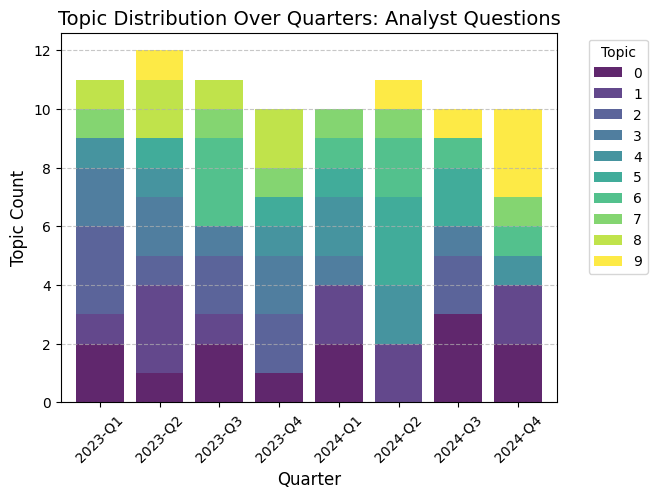

<Figure size 1200x600 with 0 Axes>

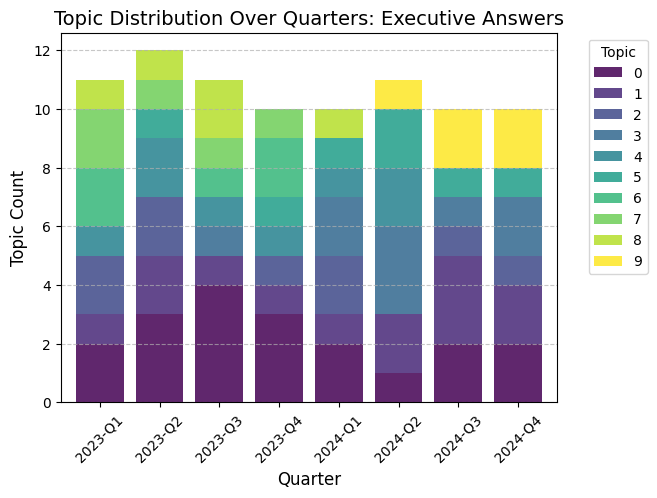

<Figure size 1200x600 with 0 Axes>

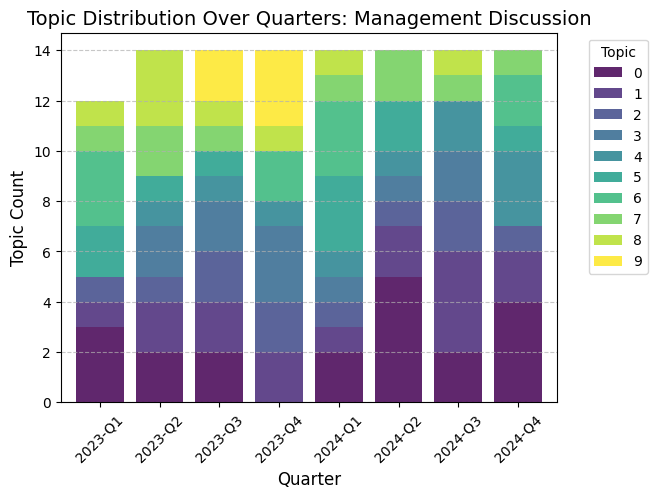

In [ ]:
# Topic trends over time

def plot_topic_trends(topic_distribution, title):
    plt.figure(figsize=(12, 6))
    topic_distribution.plot(kind="bar", stacked=True, colormap="viridis", width=0.8, alpha=0.85)

    plt.title(f"Topic Distribution Over Quarters: {title}", fontsize=14)
    plt.xlabel("Quarter", fontsize=12)
    plt.ylabel("Topic Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_topic_trends(analyst_topic_distribution, "Analyst Questions")
plot_topic_trends(executive_topic_distribution, "Executive Answers")
plot_topic_trends(mgmt_topic_distribution, "Management Discussion")

**Topic trend insights**

High level

- **Analyst Questions & Executive Answers are more dynamic** compared to Management Discussion, reflecting external financial and regulatory conditions.
- **Certain quarters (e.g., 2023-Q2 and 2024-Q2) show greater topic diversity**, possibly indicating key events (e.g., regulatory changes, macroeconomic shifts, or industry concerns). ❗**What happened in 2023-Q2 and 2024-Q2 that led to increased diversity in analyst questions and executive responses?** (this quarter also got flagged in our EDA, see addtl commentary lower down!)
- **Management Discussion remains structured and finance-focused**, with minimal quarterly changes.
- **Comparing topics across these segments can reveal areas where analysts probe more deeply and where executives shift messaging.**

Detail

**Analyst Questions**
- **2023-Q2 & 2024-Q2** show slightly more variety, suggesting analysts asked more diverse questions during these periods.
- Certain topics, such as **"capital requirements" and "liquidity," appear consistently** across quarters, indicating ongoing concerns from analysts.
- **2024-Q2 introduces new prominent topics**, potentially reflecting changes in macroeconomic conditions or regulatory developments that influenced analysts' questioning.

**Executive Answers**
- **2023-Q2 and 2024-Q2** again show more diversity in topic distribution, possibly due to specific financial events or earnings trends that required a broader response.
- Topics related to **deposits, lending, and market expectations are consistent** across quarters, showing that these remain primary concerns for executives when responding to analysts.
- **New topic emergence in later quarters (2024-Q2 and Q3)** suggests executives may be shifting their messaging in response to changing financial conditions or new regulations.

**Management Discussion**
- This section is more **structured and predictable**, focusing primarily on financial metrics, NII expectations, and regulatory discussions.
- The presence of **capital and revenue-related topics remains dominant**, aligning with the focus on performance reporting.
- The consistency across quarters confirms that this segment primarily provides structured financial updates rather than reactive responses to market conditions.


💡 more analysis could be done on topic evolution and whether there were emerging concerns in 2024 that weren't present in 2023. Also, to analyse changes in sentiment, shifts in analyst scrutiny, sudden topic diversification, and deviations in management tone as potential indicators of upcoming financial stress.

**Commentary on 2Q23, and 2Q24**

The increased diversity in topics during Q2 2023 and Q2 2024 likely reflects major regulatory changes, economic shifts, and banking sector developments.

In 2023, discussions were influenced by the removal of banker bonus caps and enhanced liquidity monitoring following banking turmoil. By Q2 2024, strong U.S. retail sales, rising household debt, and declining net interest margins shaped conversations on consumer behavior, lending practices, and profitability.

Additionally, regulatory scrutiny on liquidity risks and capital requirements contributed to a broader range of discussions. These factors highlight how external economic and regulatory events drive variations in quarterly earnings call topics.

**And so together with EDA, this is an interesting finding:**

❗EDA revealed that 2Q24 warrants special focus due to CFO's increased word count despite lower sentiment. Thereafter, topic modelling with BERTopic (completely unprompted) also flagged the same quarter as unusual due to its greater topic diversity, possibly indicating key events. Macroeconomic events at the time were indeed marked by strong US sales, however also rising household debt and declining net interest margins which we now see shaped conversations on consumer behaviour, lending practices, and profitability.

# 4. Measure tone with sentiment analysis (finBERT, Flan-T5)

## 4a) Prep data

In [ ]:
# Prep data for sentiment analysis

# standardize column names for consistency
df_analyst_topics = df_analyst_topics.rename(columns={"Question_processed": "Text_processed"})
df_executive_topics = df_executive_topics.rename(columns={"Answer_processed": "Text_processed"})

# run validation
print(" Checking DataFrame Columns (After Renaming):")
print("\n df_analyst_topics Columns:", df_analyst_topics.columns)
print(" df_executive_topics Columns:", df_executive_topics.columns)
print(" df_mgmt_topics Columns:", df_mgmt_topics.columns)

# ensure no missing columns
required_cols = ["Quarter", "Text_processed", "Topic"]

for df_name, df in zip(["Analyst Questions", "Executive Answers", "Management Discussion"],
                        [df_analyst_topics, df_executive_topics, df_mgmt_topics]):
    print(f"\n Checking {df_name} DataFrame:")

    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Missing columns in {df_name}: {missing_cols}")
    else:
        print(f" {df_name} has correct columns.")

    empty_rows = df[df["Text_processed"].str.strip() == ""]
    print(f" Empty entries in {df_name}: {len(empty_rows)}")

    print(df.head(3))

print("\n Step 1 Complete: Data validated for sentiment analysis!")

 Checking DataFrame Columns (After Renaming):

 df_analyst_topics Columns: Index(['Quarter', 'Text_processed', 'Topic'], dtype='object')
 df_executive_topics Columns: Index(['Quarter', 'Text_processed', 'Topic'], dtype='object')
 df_mgmt_topics Columns: Index(['Quarter', 'Text_processed', 'Topic'], dtype='object')

 Checking Analyst Questions DataFrame:
 Analyst Questions has correct columns.
 Empty entries in Analyst Questions: 0
   Quarter                                     Text_processed  Topic
0  2023-Q1  so jamie actually hoping get perspective see r...      0
1  2023-Q1  hey thanks good morning hey jeremy wondering g...      7
2  2023-Q1  hi thanks jeremy wanted follow drivers nii rev...      2

 Checking Executive Answers DataFrame:
 Executive Answers has correct columns.
 Empty entries in Executive Answers: 0
   Quarter                                     Text_processed  Topic
0  2023-Q1  well think already kind complete answering que...      2
1  2023-Q1  yeah sure let summar

## 4b) Run FinBERT

In [ ]:
# Run sentiment analysis with FinBERT

finbert = pipeline("text-classification", model="ProsusAI/finbert", truncation=True)

def analyze_sentiment(text):
    result = finbert(text, truncation=True)[0]
    return result["label"]

df_analyst_topics["Sentiment"] = df_analyst_topics["Text_processed"].apply(analyze_sentiment)
df_executive_topics["Sentiment"] = df_executive_topics["Text_processed"].apply(analyze_sentiment)
df_mgmt_topics["Sentiment"] = df_mgmt_topics["Text_processed"].apply(analyze_sentiment)

print("\n Sentiment Analysis Completed!")
print("\n Sample Sentiment from Analyst Questions:")
print(df_analyst_topics[["Quarter", "Text_processed", "Sentiment"]].head(3))

print("\n Sample Sentiment from Executive Answers:")
print(df_executive_topics[["Quarter", "Text_processed", "Sentiment"]].head(3))

print("\n Sample Sentiment from Management Discussion:")
print(df_mgmt_topics[["Quarter", "Text_processed", "Sentiment"]].head(3))

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu



 Sentiment Analysis Completed!

 Sample Sentiment from Analyst Questions:
   Quarter                                     Text_processed Sentiment
0  2023-Q1  so jamie actually hoping get perspective see r...   neutral
1  2023-Q1  hey thanks good morning hey jeremy wondering g...   neutral
2  2023-Q1  hi thanks jeremy wanted follow drivers nii rev...   neutral

 Sample Sentiment from Executive Answers:
   Quarter                                     Text_processed Sentiment
0  2023-Q1  well think already kind complete answering que...   neutral
1  2023-Q1  yeah sure let summarize drivers change outlook...   neutral
2  2023-Q1  yeah john really good question weve obviously ...   neutral

 Sample Sentiment from Management Discussion:
   Quarter                                     Text_processed Sentiment
0  2024-Q4  management discussion section good morning jpm...   neutral
1  2024-Q4  revolving balances card higher wholesale depos...   neutral
2  2024-Q4  20% touching couple highlights 

On quick inspection, the Q&A is mostly neutral however the management discussion has some negative sentiment possibly because it includes financial results, risks and guidance that can carry negative tones (losses, expenses, uncertainties) - **potential early warning signal if sentiment shifts more negative overtime**

In [ ]:
# Sentiment distribution for each data set

def calculate_sentiment_distribution(df, section_name):
    sentiment_counts = df["Sentiment"].value_counts(normalize=True) * 100
    sentiment_distribution = sentiment_counts.reset_index()
    sentiment_distribution.columns = ["Sentiment", "Percentage"]
    sentiment_distribution["Section"] = section_name
    return sentiment_distribution

sentiment_analyst = calculate_sentiment_distribution(df_analyst_topics, "Analyst Questions")
sentiment_executive = calculate_sentiment_distribution(df_executive_topics, "Executive Answers")
sentiment_mgmt = calculate_sentiment_distribution(df_mgmt_topics, "Management Discussion")

sentiment_overall = pd.concat([sentiment_analyst, sentiment_executive, sentiment_mgmt])

print("\n Sentiment Distribution Overview ")
print(sentiment_overall)


 Sentiment Distribution Overview 
  Sentiment  Percentage                Section
0   neutral   72.941176      Analyst Questions
1  positive   16.470588      Analyst Questions
2  negative   10.588235      Analyst Questions
0   neutral   90.588235      Executive Answers
1  positive    8.235294      Executive Answers
2  negative    1.176471      Executive Answers
0  positive   45.454545  Management Discussion
1   neutral   30.909091  Management Discussion
2  negative   23.636364  Management Discussion


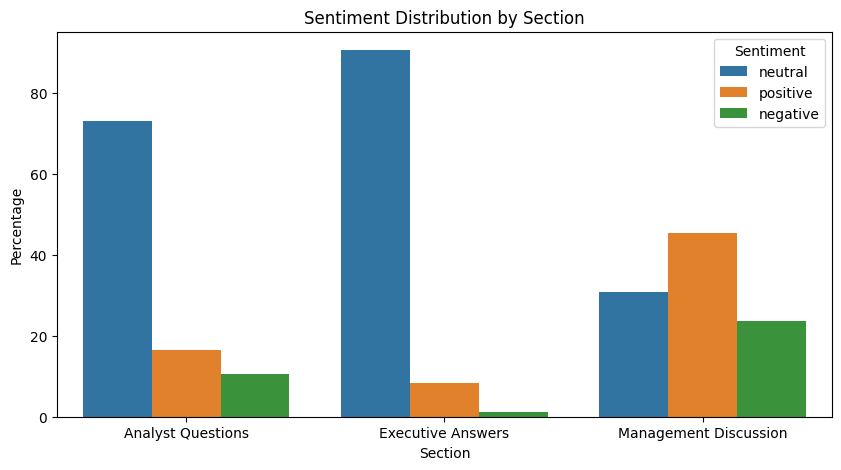

In [ ]:
# Plot sentiment distribution per section
plt.figure(figsize=(10, 5))
sns.barplot(x="Section", y="Percentage", hue="Sentiment", data=sentiment_overall)
plt.title("Sentiment Distribution by Section")
plt.xlabel("Section")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.show()

**Analyst Questions**
- Predominantly neutral (73%), with some positivity (16%) and a small but notable amount of negativity (11%).
- Fact-driven but occasionally skeptical or critical tone.

**Executive Answers**
- Overwhelmingly neutral (91%), with minimal negativity (1%) and limited positivity (8%).
- Controlled, measured response strategy to maintain a composed market image.

**Management Discussion**
- Most diverse sentiment mix: 45% positive, 31% neutral, 24% negative.
- Reflects more candid internal assessments—both optimistic about strengths and concerned about risks.

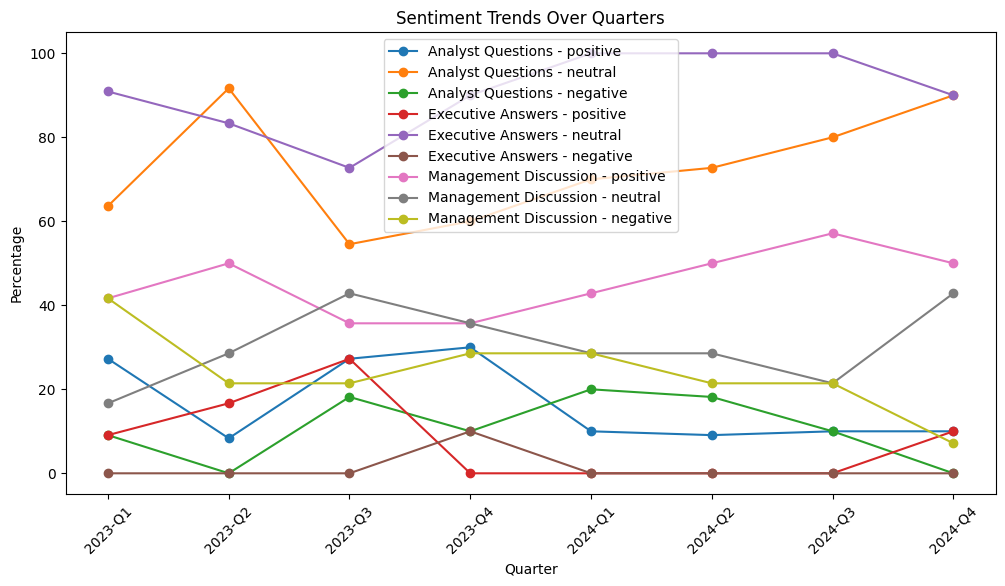

In [ ]:
# Analyse sentiment over quarters

def calculate_sentiment_trend(df, section_name):
    sentiment_trend = df.groupby(["Quarter", "Sentiment"]).size().unstack(fill_value=0)
    sentiment_trend = sentiment_trend.div(sentiment_trend.sum(axis=1), axis=0) * 100
    sentiment_trend["Section"] = section_name
    return sentiment_trend.reset_index()

trend_analyst = calculate_sentiment_trend(df_analyst_topics, "Analyst Questions")
trend_executive = calculate_sentiment_trend(df_executive_topics, "Executive Answers")
trend_mgmt = calculate_sentiment_trend(df_mgmt_topics, "Management Discussion")

plt.figure(figsize=(12, 6))

for trend_df, section in zip([trend_analyst, trend_executive, trend_mgmt],
                             ["Analyst Questions", "Executive Answers", "Management Discussion"]):
    for sentiment in ["positive", "neutral", "negative"]:
        if sentiment in trend_df.columns:
            plt.plot(trend_df["Quarter"], trend_df[sentiment], marker="o", label=f"{section} - {sentiment}")

plt.title("Sentiment Trends Over Quarters")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Observations of sentiment trends:
- Sharp drop in analyst positivity & executive positivity in 2023-Q3 & Q4, but management remains stable (or controlled)
- Executive sentiment is largely neutral throughout, except for the 2023-Q4 drop
- Management positivity is the highest of any group and rises over time

💡 2023-Q3 to 2023-Q4: What events led to lower analyst sentiment and more neutral executive responses?
There was market downturn in Q3 with global equities declining, and US stock market pulling back, then in Q4 the market started recovering with positive market performance and falling inflation.

❗ Possible correlation between topic variability and sentiment dips.
During topic analysis earlier we found that **Q2 showed a higher than typical variability in topics**. Then during sentiment analysis we saw an **unusual dip in sentiment across analysts and executives in Q3**. **Is it possible that topic variability could be correlated with sentiment dips?**
It makes sense - analysts start asking about a wider range of concerns, perhaps reflecting uncertainty due to new developments, or shifting market conditions, trying to uncover risks - and subsequently, as the emerging risks become more pronounced, and concerns materialise, the management adapts their messaging in the following quarters contributing to sentiment downturn. **THIS HIGHLIGHTS A POTENTIAL EARLY WARNING MECHANISM**

**Higher topic diversity → Analysts probing more risks → Possible sentiment decline later**

This could help identify when markets or firms are shifting into riskier periods before sentiment analysis alone picks up negative trends.

💡 Could next quantify topic variability per quarter and compare to sentiment trends to see if quarters with higher variability predict sentiment dips.


In [ ]:
# Analyse sentiment per topic

- Analyse sentiment per topic (which topics are seen positively/negatively? Do certain topics coincide with changes in sentiment?)
- Explore whether shifts in sentiment precede financial risks, using transcripts as early warning signals rather than just reflections of market conditions.
- Apply Flan-T5 (or another LLM) to re-evaluate sentiment and capture better sentiment accuracy.


# 5. Summarisation & Context Extraction

- Use Flan-T5 to summarize extracted topics.
- Compare free topics vs G-SIB-trained topics.

- Identify high-impact topics that analysts & executives discuss most.
- Extract key phrases to summarize findings concisely.



# 6. Comparative Analysis

Compare analyst topics & sentiment per quarter

Compare different analysts in the same quarter

Compare different model outputs for accuracy

1. Model Comparisons -
Compare BERTopic, FinBERT, and LLM results for accuracy.
Ensure like-for-like comparison across different model outputs.
2. Quarter-on-Quarter Analyst Comparison -
Select at least two quarters (e.g., Q4 2024 vs. Q2 2024).
Compare topics and sentiment shifts for a chosen analyst.
3. Analyst Comparisons (Same Quarter) -
Identify topic differences between analysts within the same quarter.
Check sentiment variation across analysts.1.

# 📔 Archive (LDA test on uncleaned data)

Run LDA first to confirm topic modelling is feasible on this dataset.

In [ ]:
# Run LDA on Q&A dataset

qna_texts = pd.concat([qna["Question"].dropna(), qna["Response"].dropna()])

# remove very short text entries
qna_texts = qna_texts[qna_texts.str.len() > 15].drop_duplicates()

# preprocess for LDA
qna_processed = qna_texts.apply(preprocess_string)
dictionary = corpora.Dictionary(qna_processed)
corpus = [dictionary.doc2bow(text) for text in qna_processed]

num_topics = 10
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

print("\nExtracted Topics from LDA:")
for idx, topic in lda_model.show_topics(num_topics=num_topics, formatted=True):
    print(f"Topic {idx}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Extracted Topics from LDA:
Topic 0: 0.016*"think" + 0.014*"mean" + 0.014*"capit" + 0.010*"like" + 0.009*"product" + 0.009*"term" + 0.009*"demand" + 0.009*"price" + 0.009*"economi" + 0.008*"loan"
Topic 1: 0.025*"think" + 0.012*"right" + 0.011*"like" + 0.010*"question" + 0.009*"thing" + 0.009*"point" + 0.009*"deposit" + 0.009*"capit" + 0.009*"actual" + 0.008*"bit"
Topic 2: 0.015*"think" + 0.014*"capit" + 0.013*"rate" + 0.011*"sort" + 0.010*"differ" + 0.010*"chang" + 0.009*"yeah" + 0.009*"know" + 0.009*"lot" + 0.008*"obvious"
Topic 3: 0.022*"bit" + 0.021*"littl" + 0.018*"think" + 0.018*"rate" + 0.013*"expect" + 0.010*"market" + 0.010*"sort" + 0.010*"environ" + 0.009*"term" + 0.009*"yeah"
Topic 4: 0.013*"year" + 0.012*"question" + 0.011*"driver" + 0.010*"quarter" + 0.010*"invest" + 0.009*"bear" + 0.009*"nii" + 0.008*"busi" + 0.008*"sequenti" + 0.008*"good"
Topic 5: 0.025*"year" + 0.015*"look" + 0.013*"want" + 0.013*"question" + 0.012*"good" + 0.012*"credit" + 0.012*"think" + 0.011*"like" 

In [ ]:
# Run LDA on Management dataset

management_texts = management["Transcript"].dropna()

# remove very short text entries
management_texts = management_texts[management_texts.str.len() > 15].drop_duplicates()

# preprocess for LDA
management_processed = management_texts.apply(preprocess_string)
dictionary_mgmt = corpora.Dictionary(management_processed)
corpus_mgmt = [dictionary_mgmt.doc2bow(text) for text in management_processed]

num_topics = 6
lda_model_mgmt = LdaModel(corpus=corpus_mgmt, id2word=dictionary_mgmt, num_topics=num_topics, passes=10)

print("\nExtracted Topics from LDA (Management Discussion):")
for idx, topic in lda_model_mgmt.show_topics(num_topics=num_topics, formatted=True):
    print(f"Topic {idx}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Extracted Topics from LDA (Management Discussion):
Topic 0: 0.058*"year" + 0.037*"billion" + 0.025*"net" + 0.020*"revenu" + 0.020*"driven" + 0.019*"quarter" + 0.019*"higher" + 0.016*"market" + 0.015*"million" + 0.011*"deposit"
Topic 1: 0.002*"year" + 0.002*"billion" + 0.001*"net" + 0.001*"revenu" + 0.001*"million" + 0.001*"driven" + 0.001*"quarter" + 0.001*"higher" + 0.001*"expens" + 0.001*"page"
Topic 2: 0.003*"year" + 0.002*"billion" + 0.002*"net" + 0.002*"quarter" + 0.002*"market" + 0.002*"million" + 0.002*"higher" + 0.001*"revenu" + 0.001*"driven" + 0.001*"deposit"
Topic 3: 0.004*"year" + 0.002*"billion" + 0.002*"quarter" + 0.002*"driven" + 0.002*"net" + 0.002*"revenu" + 0.002*"higher" + 0.002*"million" + 0.001*"expens" + 0.001*"market"
Topic 4: 0.058*"year" + 0.032*"billion" + 0.023*"quarter" + 0.020*"net" + 0.017*"driven" + 0.017*"revenu" + 0.015*"higher" + 0.014*"million" + 0.014*"market" + 0.011*"deposit"
Topic 5: 0.004*"year" + 0.004*"billion" + 0.003*"net" + 0.003*"quarter" 

In [ ]:
# Visualise LDA topics

print("\nGenerating LDA visualization for Q&A...")
lda_vis_qna = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_vis_qna, "LDA_QnA_Visualization.html")

print("\nGenerating LDA visualization for Management Discussion...")
lda_vis_mgmt = gensimvis.prepare(lda_model_mgmt, corpus_mgmt, dictionary_mgmt)
pyLDAvis.save_html(lda_vis_mgmt, "LDA_Management_Visualization.html")

print("\nDisplaying LDA Visualization for Q&A:")
display(HTML("LDA_QnA_Visualization.html"))

print("\nDisplaying LDA Visualization for Management Discussion:")
display(HTML("LDA_Management_Visualization.html"))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Generating LDA visualization for Q&A...

Generating LDA visualization for Management Discussion...

Displaying LDA Visualization for Q&A:



Displaying LDA Visualization for Management Discussion:
